In [2]:
from os import listdir
from os.path import isfile, join

import json
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from datetime import date
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


from pmdarima.arima import auto_arima
import statsmodels.tsa.api as smt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import rmse

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error

import math

/tmp/ipykernel_756042/3180281715.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Use ARIMA to predict NFT floor price using tweets

In [3]:
df = pd.read_csv('price/clonex_floor_price.csv')
df.head()

,timestamp,floor_price
0,2022-08-01 00:00:00,7.50
1,2022-08-02 00:00:00,7.49
2,2022-08-03 00:00:00,7.49
3,2022-08-04 00:00:00,6.99
4,2022-08-05 00:00:00,8.10


In [4]:
df['date'] = pd.to_datetime(df['timestamp'])
df = df[['date', 'floor_price']]
df.set_index('date', inplace = True)
df.head()

,floor_price
date,
2022-08-01,7.50
2022-08-02,7.49
2022-08-03,7.49
2022-08-04,6.99
2022-08-05,8.10


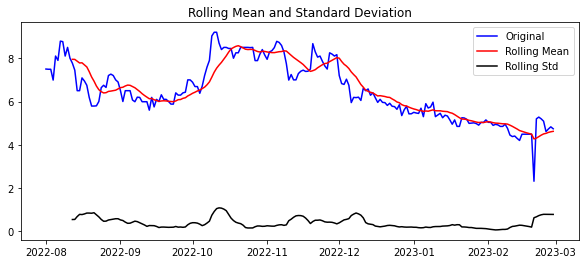

Results of dickey fuller test
Test Statistics                 -1.637497
p-value                          0.463569
No. of lags used                 1.000000
Number of observations used    210.000000
critical value (1%)             -3.461879
critical value (5%)             -2.875404
critical value (10%)            -2.574159
dtype: float64


In [5]:
# stationary check
def test_stationarity(timeseries):
    fig = plt.figure(figsize=(10, 4))
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df)
# p value smaller than 0.05

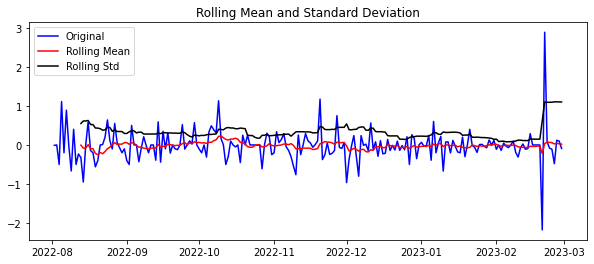

Results of dickey fuller test
Test Statistics               -1.793091e+01
p-value                        2.883447e-30
No. of lags used               0.000000e+00
Number of observations used    2.100000e+02
critical value (1%)           -3.461879e+00
critical value (5%)           -2.875404e+00
critical value (10%)          -2.574159e+00
dtype: float64


In [6]:
df_diff = df.copy()
df_diff = df_diff.diff().dropna()
test_stationarity(df_diff)

In [7]:
from sklearn.model_selection import train_test_split

def train_test_split_(df, train_size = 0.8):
    train_index = int(len(df) * train_size)

    train_set = df[:train_index]
    test_set = df[train_index:]

    print(f"Number of training samples: {len(train_set)}")
    print(f"Number of test samples: {len(test_set)}")
    
    return train_set, test_set

In [8]:
train_set, test_set = train_test_split_(df_diff)
train_set.shape, test_set.shape

Number of training samples: 168
Number of test samples: 43


((168, 1), (43, 1))

In [9]:
train_set.head()

,floor_price
date,
2022-08-02,-0.01
2022-08-03,0.00
2022-08-04,-0.50
2022-08-05,1.11
2022-08-06,-0.20


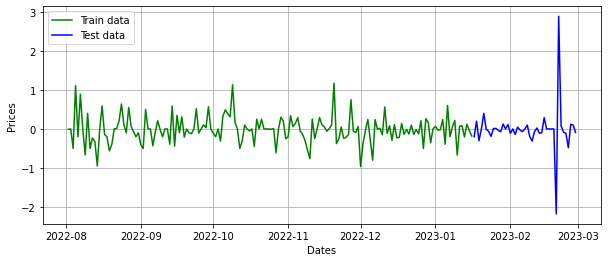

In [10]:
plt.figure(figsize=(10,4))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_set, 'green', label='Train data')
plt.plot(test_set, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=119.825, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=121.275, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=121.321, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=123.141, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=121.547, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.203 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  168
Model:                        SARIMAX   Log Likelihood                 -58.913
Date:                Fri, 21 Apr 2023   AIC                            119.825
Time:                        00:55:57   BIC                            122.949
Sample:                    08-02-2022   HQIC                           121.093
                         - 01-16-2023                                         
Co

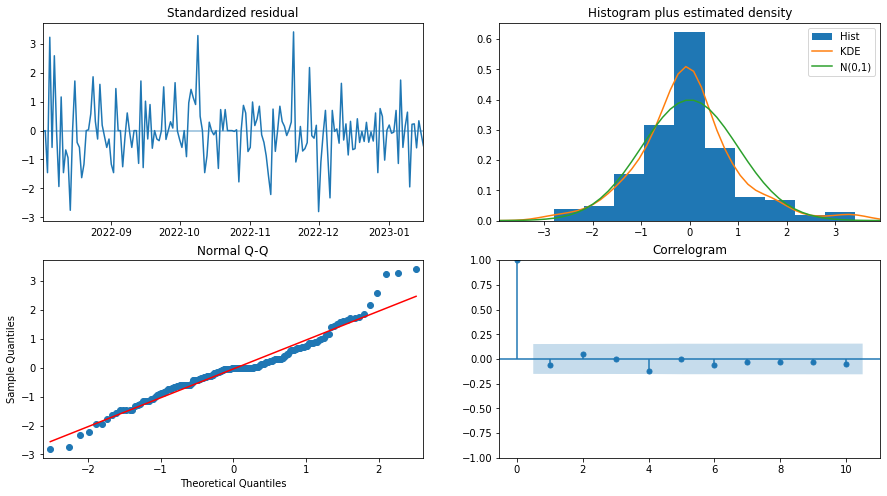

In [11]:
model_autoARIMA = auto_arima(train_set, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [12]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_set, order=(0,0,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:            floor_price   No. Observations:                  168
Model:                          ARIMA   Log Likelihood                 -58.773
Date:                Fri, 21 Apr 2023   AIC                            121.547
Time:                        00:55:59   BIC                            127.794
Sample:                    08-02-2022   HQIC                           124.082
                         - 01-16-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0140      0.027     -0.512      0.609      -0.068       0.040
sigma2         0.1179      0.010     12.209      0.000       0.099       0.137
Ljung-Box (L1) (Q):                   0.59   Jarque-

/home/bingqiao/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/bingqiao/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/bingqiao/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Inverse difference
def inverse_difference(last_ob, value):
    return value + last_ob

# Forecasting
fc = fitted.forecast(len(test_set))  # Forecast values
fc_series = pd.Series(fc, index=test_set.index)

# Reverse the diff
last_value = df.iloc[len(train_set) - 1, 0]
forecast = []
for value in fc_series:
    inverted_value = inverse_difference(last_value, value)
    forecast.append(inverted_value)
    last_value = inverted_value

forecast_series = pd.Series(forecast, index=test_set.index)

# Calculate RMSE and MSE
rmse = np.sqrt(mean_squared_error(df[len(train_set)+1:], forecast_series))
mse = mean_squared_error(df[len(train_set)+1:], forecast_series)
print("RMSE:", rmse)
print("MSE:", mse)


RMSE: 0.4971155631899396
MSE: 0.24712388316565084
